# Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*


student: Imane SI SALAH

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from scipy import signal


## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _, Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

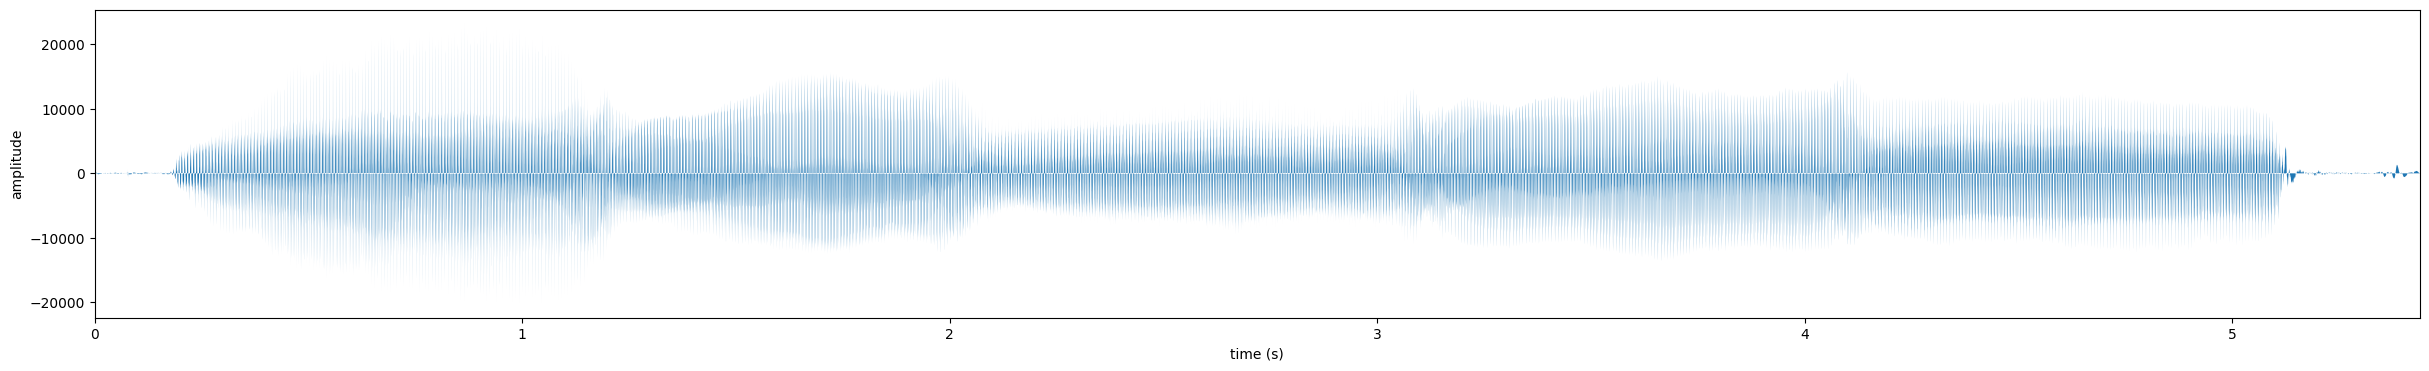

In [8]:
plot_sound(x, times)

In [9]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

<h2>1. Extraction of the analysis marks</h2>

In [10]:
def AnalysisPitchMarks(s,Fs):
     #start intialize time 
    ta=[0]
     #initialoze the perdiop
    Pa=[int(0.01* Fs)]
    # initialize voiced:
    voiced=[False]
    #start the loop 
    A=[]
    for i in range(len(s)):
        x= s[ta[-1]: ta[-1]+ int(2.5*Pa[-1])]
        P_n, voiced_n= period(x, Fs)
        t_n= int(ta[-1]+P_n)
        ta.append(int(t_n))
        Pa.append(int(P_n))
        voiced.append(bool(voiced_n))
        if ta[-1]+Pa[-1]>(len(s)):
            break
    # print(ta)
    # print(voiced)
    # print(Pa)
    A=np.vstack([ta[:], voiced[:],Pa[:]])
    return A
A= AnalysisPitchMarks(x,Fs)
print(A.shape)

(3, 708)


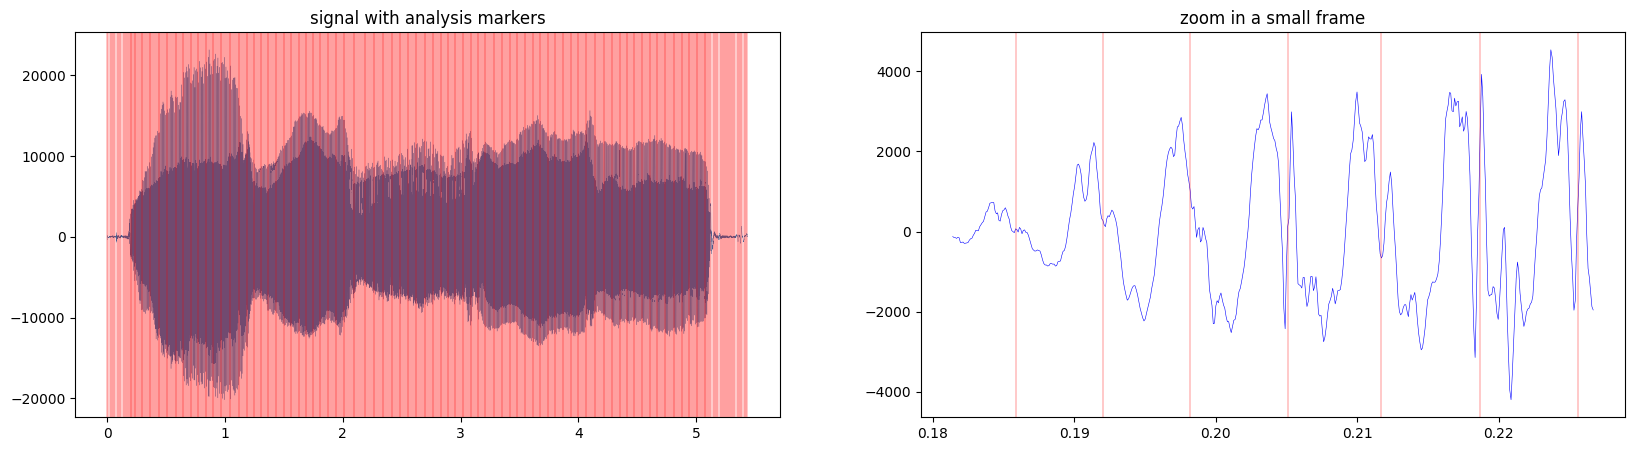

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(times, x, linewidth=0.2)
markers= A[0, :]
for k in markers:
    plt.axvline(k/Fs, linestyle='-', color='red', linewidth=0.3)
plt.title('signal with analysis markers')

plt.subplot(1,2,2)
plt.plot(times[2000:2500], x[2000:2500], linewidth=0.4, color='blue', label='X')
A1= A[:,A[0,:]>2000]
A2= A1[0, A1[0,:]<2500]
markers= A2
for k in markers:
    plt.axvline(k/Fs, linestyle='-', color='red', linewidth=0.3)
plt.title('zoom in a small frame')
plt.show()

<h2>2. Synthesis and modification of the temporal and spectral scales</h2>
<h3>2.1 Signal synthesis</h3>

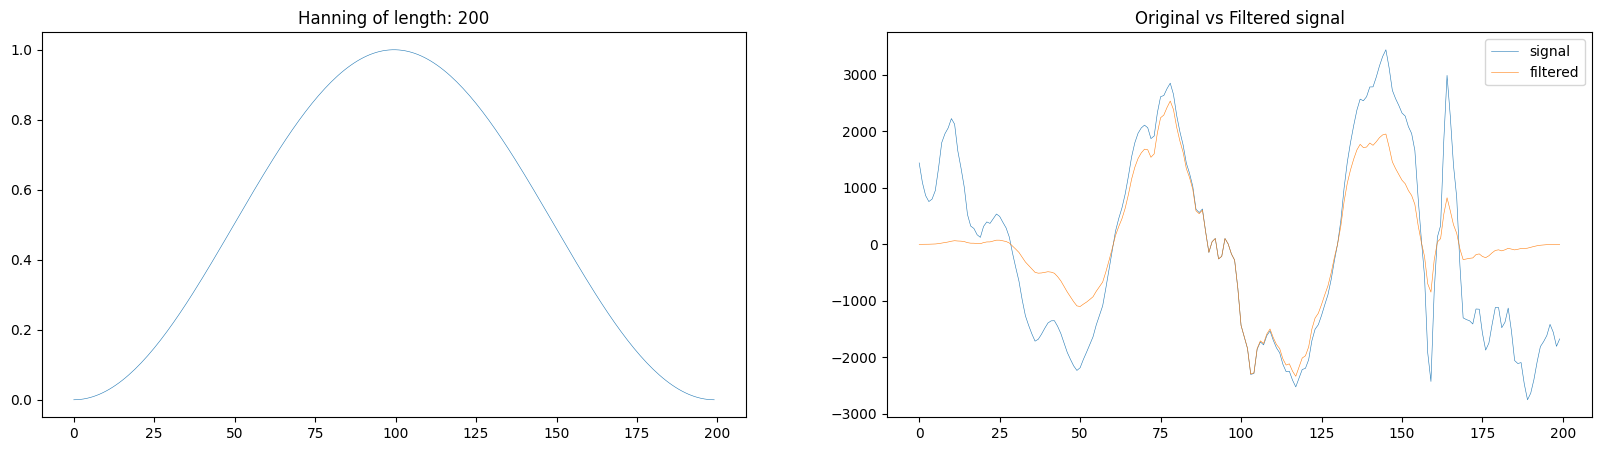

In [33]:
#quickly explore the effect of the hannign window
s= x[2100: 2300]
win= signal.hann(len(s))
filtered= s*win

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(win, linewidth=0.4)
plt.title(f'Hanning of length: {len(s)}')

plt.subplot(1,2,2)
plt.plot(s,linewidth=0.4 ,label='signal')
plt.plot(filtered, linewidth=0.4, label='filtered')
plt.legend()
plt.title('Original vs Filtered signal')
plt.show()

In [13]:
def Synthesis(s,Fs,A,B):
    y=np.zeros((1,B[0,-1]+ A[2,B[1,-1]])) # intialize y to zeros of lenght ts(kend)+ Pa(n(kend)
    for k in range(1,B.shape[1]):
        ta= A[0,B[1,k]]
        ts= B[0,k]
        Pnk= A[2,B[1,k]]
        if  ts+ Pnk>y.shape[1]:
            break
        if ts>Pnk and (ts+ Pnk)<y.shape[1]:
            x= s[ta: ta+ 2*Pnk]
            x_windowed= x*signal.hanning(len(x))
            if y[0, ts- Pnk: ts+ Pnk ].shape == x_windowed.shape:
                y[0, ts- Pnk: ts+ Pnk ]+= x_windowed
    return y

c:\Users\imane\MVA\audio signal indexing\TP2\.venv\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  # This is added back by InteractiveShellApp.init_path()


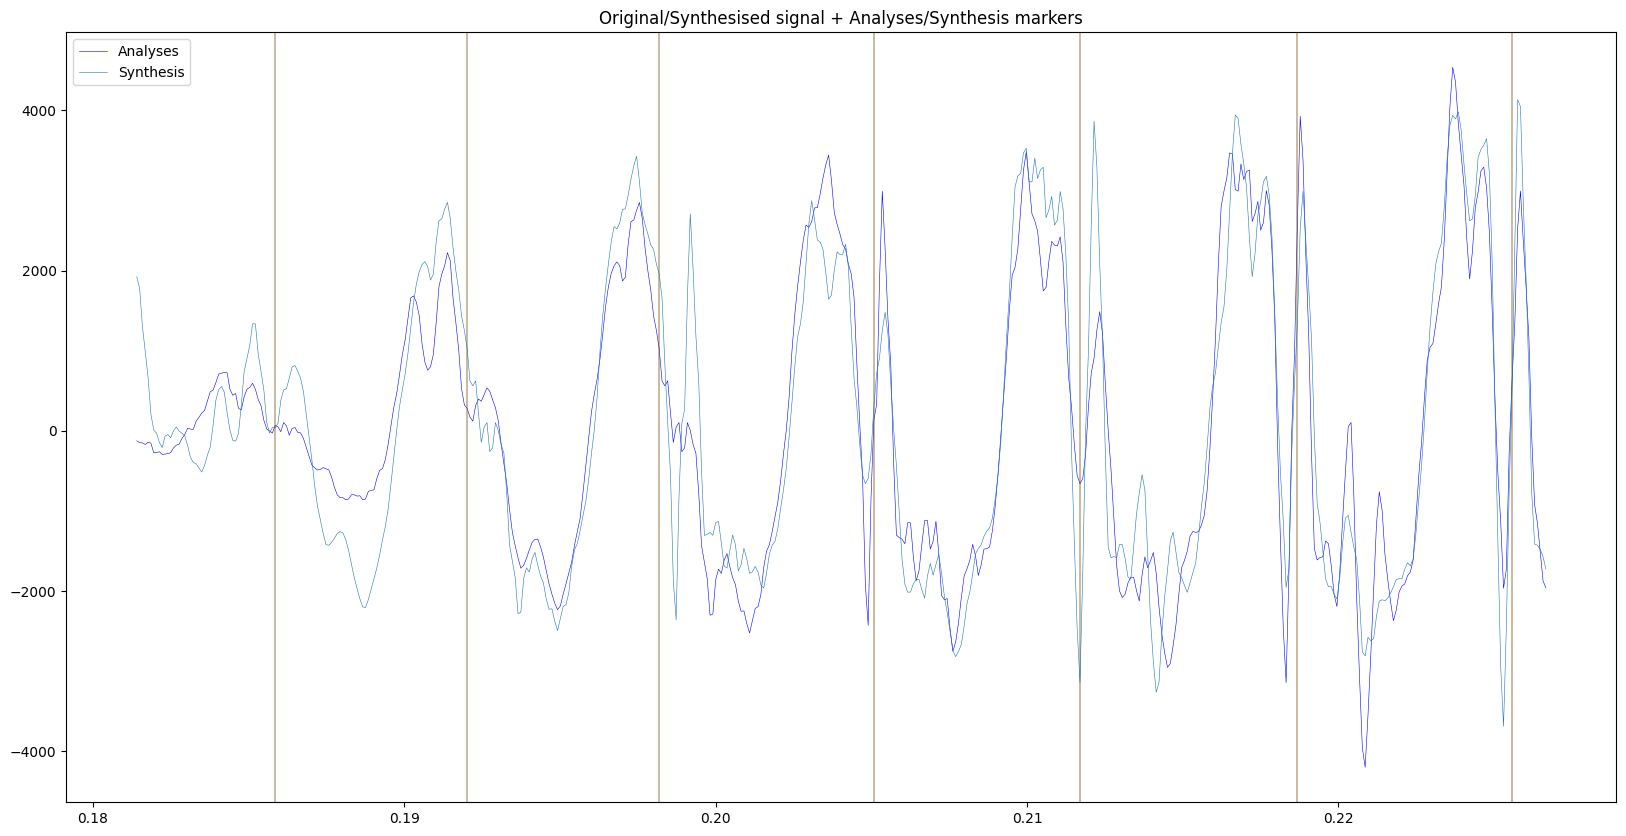

In [14]:
#try it out
B=np.zeros((2,A.shape[1]), dtype=int)
B[0,:]= np.copy(A[0,:])
B[1,:]= np.arange(A.shape[1])

y= Synthesis(x,Fs,A,B)
times_y= np.arange(y.shape[1])/Fs
plt.figure(figsize=(20,10))

plt.plot(times[2000:2500], x[2000:2500], linewidth=0.4, color='blue', label='Analyses')

A1= A[:,A[0,:]>2000]
A2= A1[0, A1[0,:]<2500]
markers= A2
for k in markers:
    plt.axvline(k/Fs, linestyle='-', color='red', linewidth=0.3)

plt.plot(times_y[2000:2500], y[0,2000:2500].squeeze(), linewidth=0.4, label='Synthesis')
B1= B[:,B[0,:]>2000]
B2= B1[0, B1[0,:]<2500]
markers= B2
for k in markers:
    plt.axvline(k/Fs, linestyle='-', linewidth=0.3, color='green')
plt.legend()
plt.title('Original/Synthesised signal + Analyses/Synthesis markers')
plt.show()



We see the that indeed the analysis and the synthesis markers overlap just as we initialized B, we also see the filtering effect on the signal

<h3> 2.2 Modification of the temporal scale</h3>

In [15]:
def ChangeTimeScale(alpha,A,Fs):
    ts=[0]
    n_k=[0]
    Pa=A[2,:]
    print(n_k[-1])

    while n_k[-1]< A.shape[1]-2:
        ts_next= ts[-1]+ Pa[int(np.floor(n_k[-1]))]
        n_k_next= n_k[-1]+1/alpha
        ts.append(ts_next)
        n_k.append(n_k_next)
    
    n_k[:]= [int(n_k[i]) for i in range(len(n_k)) ]
    # print(ts)
    # print(n_k)
    B=np.vstack([ts[:], n_k[:]])
    return B


0


c:\Users\imane\MVA\audio signal indexing\TP2\.venv\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  # This is added back by InteractiveShellApp.init_path()


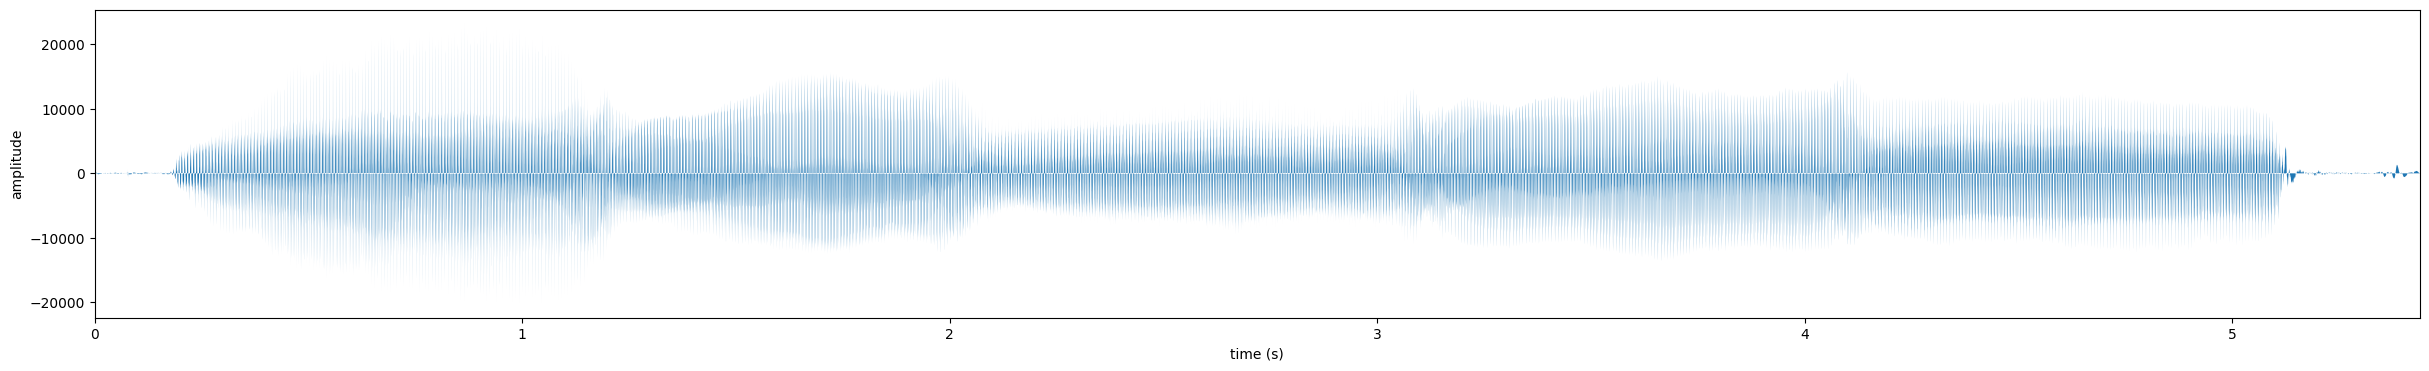

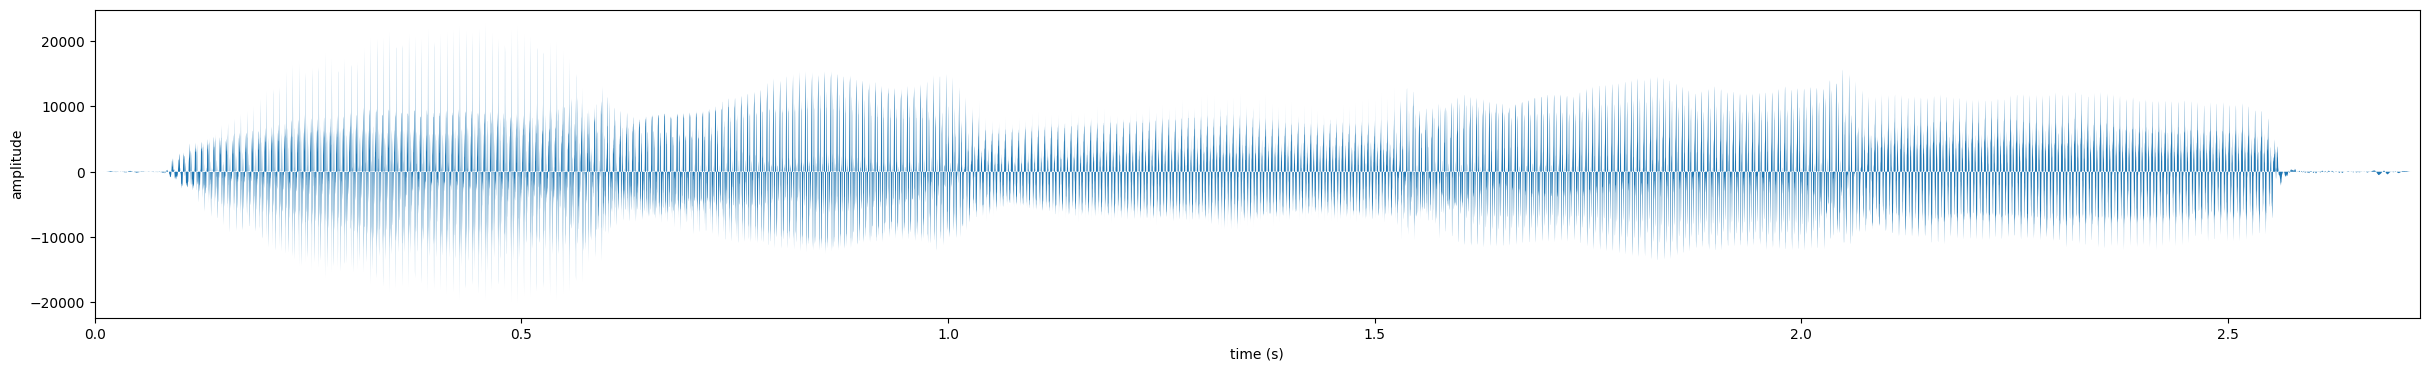

In [16]:
#testing 

alpha= 0.5

A= AnalysisPitchMarks(x,Fs)
B= ChangeTimeScale(alpha,A,Fs)
y= Synthesis(x,Fs,A,B)

times_y= np.arange(y.shape[1])/Fs

plot_sound(x, times)
plot_sound(y.squeeze(), times_y)


we clearly see how the duration has been devided by 2 for alpha=0.5

In [17]:
IPython.display.Audio(x, rate=Fs)

In [18]:
IPython.display.Audio(y, rate=Fs)

In [19]:
print(np.min(A[2,:]))
f1= Fs*np.min(A[2,:])/len(x)
t1=1/f1
print(t1)

41
0.13265637962502075


<h3>2.3 Modfication of the spectral scale</h3>

In [20]:
print(A[1,67])
p= 1 if A[1,67] else 3
print(p)

1
1


In [21]:
def ChangePitchScale(beta,A,Fs):
    ts=[0]
    n_k=[0]
    Pa=A[2,:]
    voiced= A[1,:]
    print(n_k[-1])

    while n_k[-1]< A.shape[1]-2:
        #define scale:
        scale_k= 1/beta if voiced[int(np.floor(n_k [-1]))] else 1

        ts_next= ts[-1]+ Pa[int(np.floor(n_k[-1]))]* scale_k
        n_k_next= n_k[-1]+scale_k
        ts.append(ts_next)
        n_k.append(n_k_next)
    
    ts[:]= [int(ts[i]) for i in range(len(ts)) ]
    n_k[:]= [int(n_k[i]) for i in range(len(n_k)) ]
    # print(ts)
    # print(n_k)
    B=np.vstack([ts[:], n_k[:]])
    return B

0


c:\Users\imane\MVA\audio signal indexing\TP2\.venv\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  # This is added back by InteractiveShellApp.init_path()


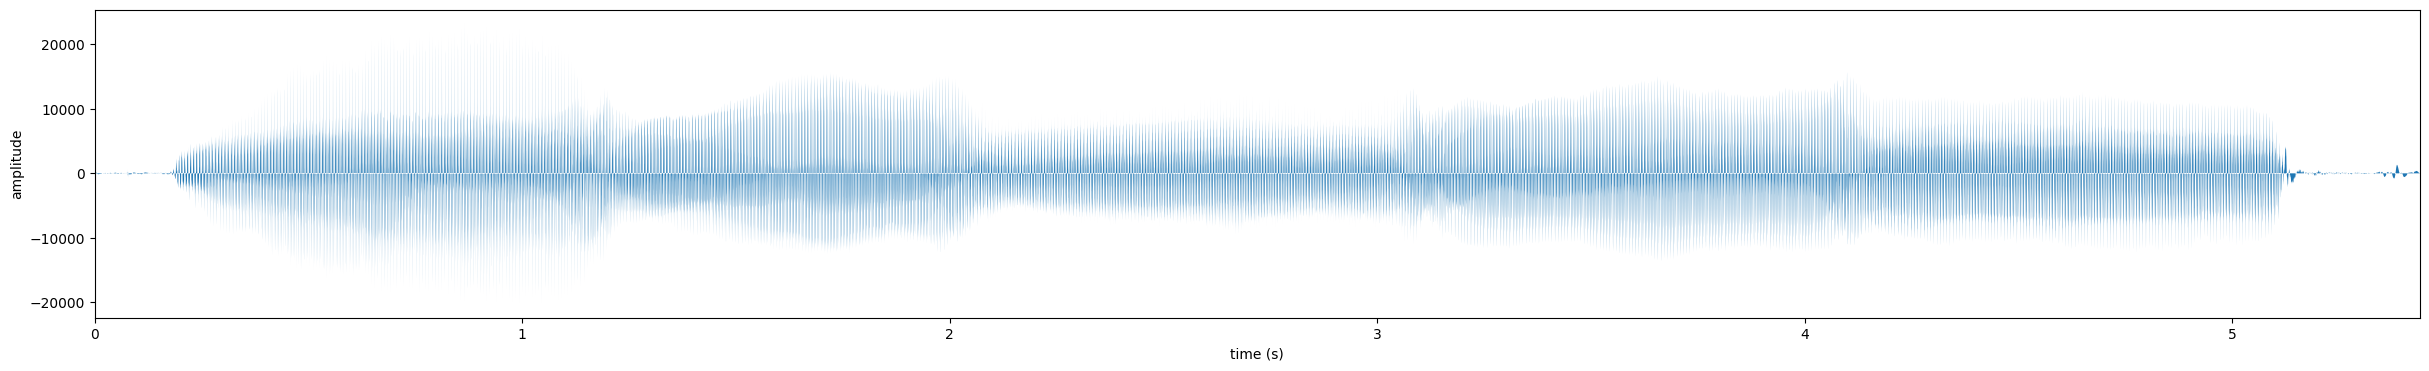

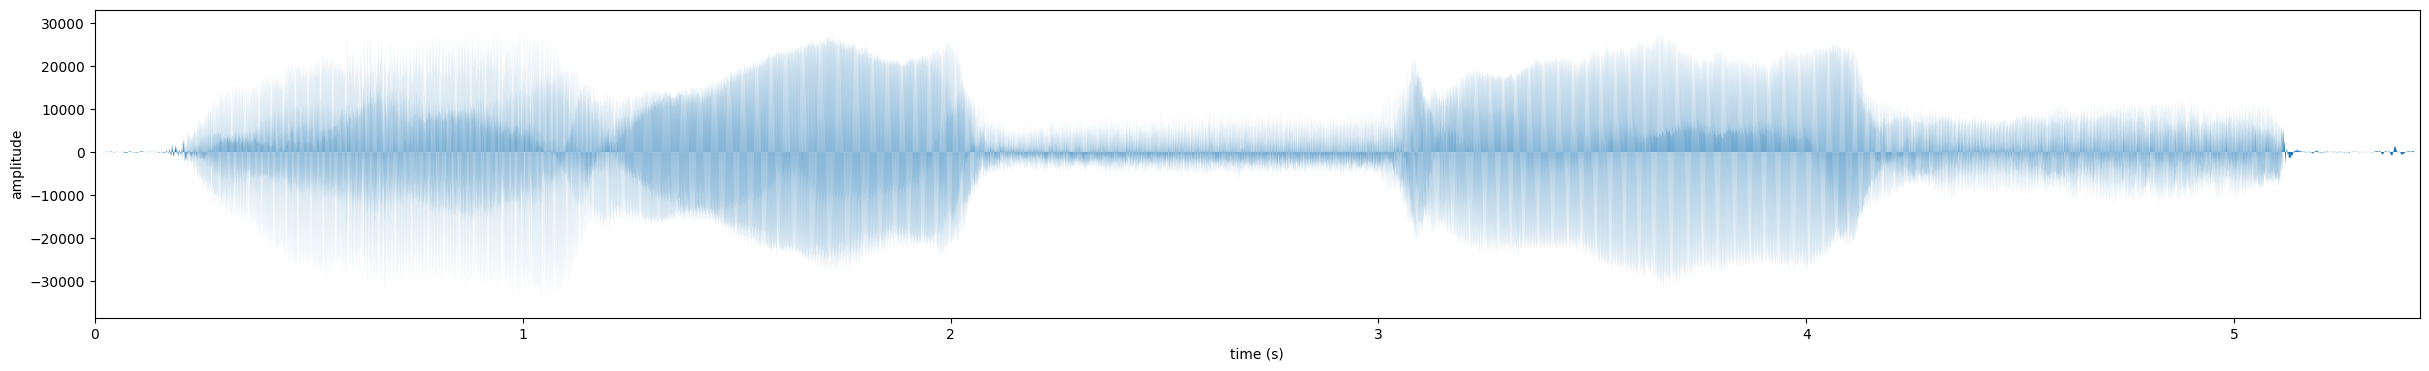

In [22]:
beta= 3
A= AnalysisPitchMarks(x,Fs)
B= ChangePitchScale(beta,A,Fs)
y= Synthesis(x,Fs,A,B)

times_y= np.arange(y.shape[1])/Fs

plot_sound(x, times)
plot_sound(y.squeeze(), times_y)


In [23]:
IPython.display.Audio(x, rate=Fs)

In [24]:
IPython.display.Audio(y, rate=Fs)

<h3>2.4 Joint modification of the temporal and spectral scales </h3>

In [25]:
def ChangeBothScales(alpha, beta,A,Fs):
    ts=[0]
    n_k=[0]
    Pa=A[2,:]
    voiced= A[1,:]
    print(n_k[-1])

    while n_k[-1]< A.shape[1]-2:
        #define scale:
        scale_k= 1/beta if voiced[int(np.floor(n_k [-1]))] else 1
        ts_next= ts[-1]+ Pa[int(np.floor(n_k[-1]))]* scale_k
        n_k_next= n_k[-1]+ 1/alpha
        ts.append(ts_next)
        n_k.append(n_k_next)
    
    ts[:]= [int(ts[i]) for i in range(len(ts)) ]
    n_k[:]= [int(n_k[i]) for i in range(len(n_k)) ]
    # print(ts)
    # print(n_k)
    B=np.vstack([ts[:], n_k[:]])
    return B

B= ChangeBothScales(0.33,2, A,Fs)
print(A.shape)
print(B.shape)

0
(3, 708)
(2, 234)


0


c:\Users\imane\MVA\audio signal indexing\TP2\.venv\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  # This is added back by InteractiveShellApp.init_path()


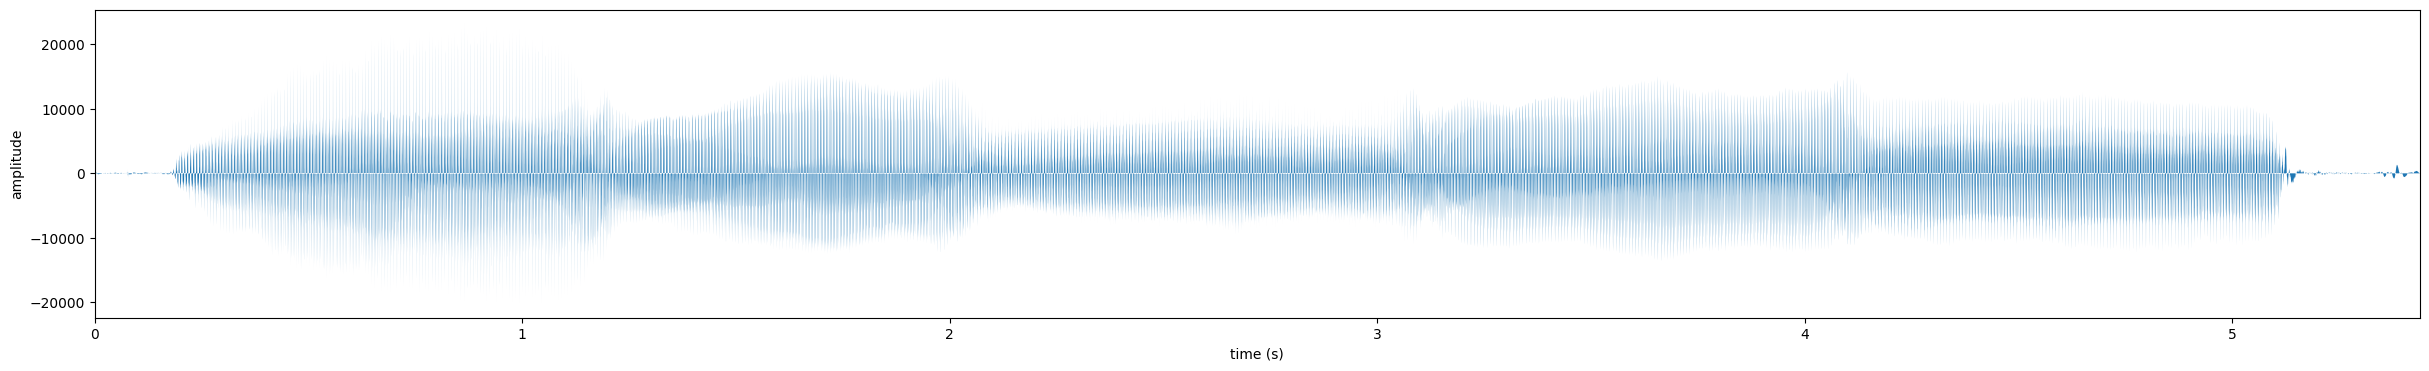

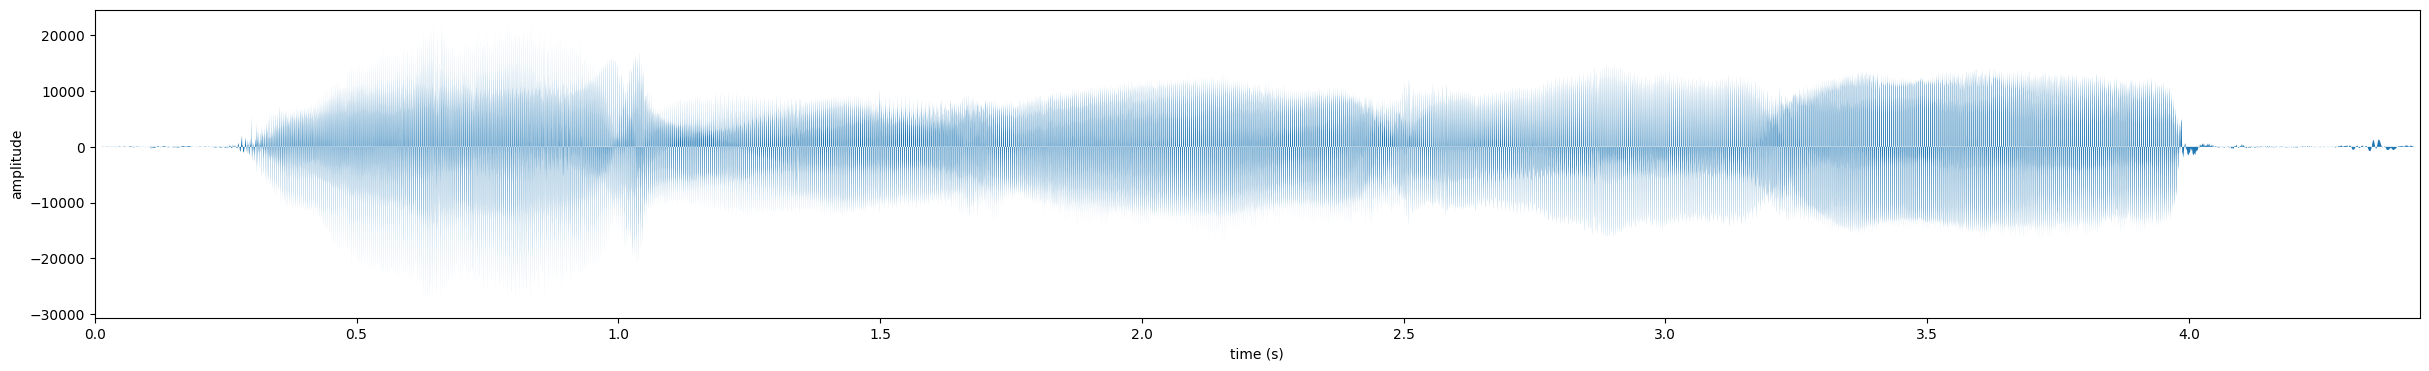

In [26]:
alpha=1.5
beta= 2
A= AnalysisPitchMarks(x,Fs)
B= ChangeBothScales(alpha, beta,A,Fs)
y= Synthesis(x,Fs,A,B)

times_y= np.arange(y.shape[1])/Fs

plot_sound(x, times)
plot_sound(y.squeeze(), times_y)

In [27]:
IPython.display.Audio(y, rate=Fs)